In [18]:
import torch as T 
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader  
from torch.nn.utils import spectral_norm
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2  
import random  
import time  

# Global Variable

In [19]:
T.autograd.set_detect_anomaly(True)

path_train = 'E:/data/DeepLearning/动漫老婆/'  
path_test = 'E:/data/DeepLearning/动漫老婆/'  
channels_condition = 100
device = T.device("cuda:0") if T.cuda.is_available() else T.device("cpu")
channel_g = 64
depth_g = 6
depth_d = 3
channel_d = 64
num_workers = 0
batch_size = 16
λ_pix = 1e2
λ_gp = 10
learning_rate_g = 2e-4
learning_rate_d = 1e-4
path_work = 'D:/model/colorgan/model/'
step_g = 1

# Data

In [20]:
class Dataset_(Dataset):
    #
    def __init__(self, path, patch_size=[64,64]):
        self.path = path
        self.list = os.listdir(path)
        self.patch_size = patch_size
    #
    def __len__(self):
        return len(self.list)
    #
    def __getitem__(self, idx):
        #
        image_color = cv2.imdecode(np.fromfile(os.path.join(self.path, self.list[idx]), dtype=np.uint8), cv2.IMREAD_COLOR) / 255.0
        # image_color2 = cv2.imdecode(np.fromfile(os.path.join(self.path, self.list[random.randint(0, len(self.list)-1)]), dtype=np.uint8), cv2.IMREAD_COLOR) / 255.0
        if random.randint(0, 1):
            image_color = image_color[:,::-1,:]
        image_gray = 0.299 * image_color[:,:,2] + 0.587 * image_color[:,:,1] + 0.114 * image_color[:,:,0]
        # image_gray = 0.299 * image_color2[:,:,2] + 0.587 * image_color2[:,:,1] + 0.114 * image_color2[:,:,0]
        #
        image_gray, image_color = self.get_patch(image_gray, image_color)
        #
        image_gray = image_gray.reshape([1, image_gray.shape[0], image_gray.shape[1]]).astype(np.float32)
        image_color = image_color[:,:,::-1].transpose(2, 0, 1).reshape([3, image_color.shape[0], image_color.shape[1]]).astype(np.float32)
        return image_gray, image_color.copy()
    #
    def get_patch(self, image_a, image_b):
        h_min, w_min = random.randint(0, image_a.shape[0]-self.patch_size[0]), random.randint(0, image_a.shape[1]-self.patch_size[1])
        image_a_patch = image_a[h_min:h_min+self.patch_size[0], w_min:w_min+self.patch_size[1], ...]
        # h_min, w_min = random.randint(0, image_b.shape[0]-self.patch_size[0]), random.randint(0, image_b.shape[1]-self.patch_size[1])
        image_b_patch = image_b[h_min:h_min+self.patch_size[0], w_min:w_min+self.patch_size[1], ...]
        return image_a_patch, image_b_patch

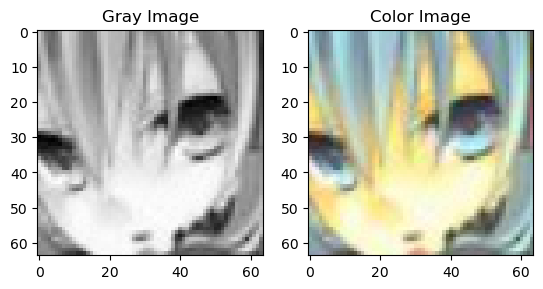

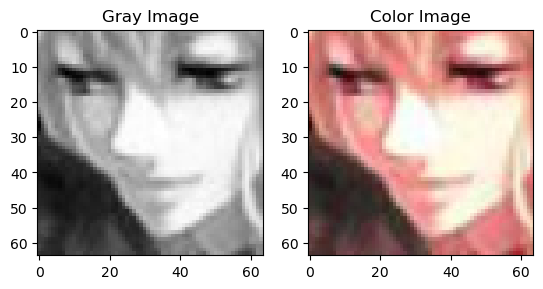

In [21]:
dataloader = DataLoader(Dataset_(path_train), batch_size=1, shuffle=True)

for i, (image_gray, image_color) in enumerate(dataloader):
    image_gray = image_gray.squeeze().numpy() #* 0.5 + 0.5
    image_color = image_color.squeeze().permute(1,2,0).numpy() #* 0.5 + 0.5
    plt.subplot(1,2,1), plt.imshow(image_gray, cmap='gray'), plt.title('Gray Image')
    plt.subplot(1,2,2), plt.imshow(image_color), plt.title('Color Image')
    plt.show()
    if i==1:
        break

# Network Structure

## Generator

In [22]:
class CIN(nn.Module):
    #
    def __init__(self, channels_feature, channels_condition):
        super().__init__()
        channels = channels_feature + channels_condition
        self.fc_mean = nn.Sequential(nn.Conv2d(channels, channels, 1), nn.ReLU(), nn.Conv2d(channels, channels_feature, 1))
        self.fc_std = nn.Sequential(nn.Conv2d(channels, channels, 1), nn.ReLU(), nn.Conv2d(channels, channels_feature, 1))
    #
    def forward(self, x, c):
        mean = T.mean(x, dim=[2,3], keepdim=True)
        std = T.sqrt(T.var(x, dim=[2,3], keepdim=True) + 1e-5)
        mean_c = T.cat([mean, c], dim=1)
        std_c = T.cat([std, c], dim=1)
        print('---', self.fc_mean(mean_c).min(), self.fc_mean(mean_c).max(), self.fc_std(std_c).min(), self.fc_std(std_c).max())
        mean_c = self.fc_mean(mean_c) + mean
        std_c = self.fc_std(std_c) + std
        print('===', mean.min(), mean.max(), std.min(), std.max())
        return (x - mean) / std * std_c + mean_c

In [23]:
class CNA(nn.Module):
    #
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding, channels_condition, is_conv=True, is_act=True):
        super().__init__()
        if is_conv:
            self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=False)
        else:
            self.conv = nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, bias=False)
        self.norm = CIN(out_channels, channels_condition)
        if is_act:
            self.act = nn.ReLU()
        else:
            self.act = nn.Identity()
    #
    def forward(self, x, c):
        x = self.conv(x)
        x = self.norm(x, c)
        x = self.act(x)
        return x

In [24]:
class ResBlock(nn.Module):
    #
    def __init__(self, channel, channels_condition):
        super().__init__()
        self.layers = nn.ModuleList([CNA(channel, channel, 3, 1, 1, channels_condition, True, True), 
                                     CNA(channel, channel, 3, 1, 1, channels_condition, True, False)])
    #
    def forward(self, x, c):
        y = x.clone()
        for layer in self.layers:
            x = layer(x, c)
        return x + y

In [25]:
class Generator(nn.Module):
    #
    def __init__(self, channel=channel_g, depth=depth_g, channels_condition=channels_condition):
        super().__init__()
        self.conv1 = CNA(1, channel, 7, 1, 3, channels_condition, True)
        self.layers = nn.ModuleList()
        self.layers.append(CNA(channel, channel*2, 4, 2, 1, channels_condition, True))
        self.layers.append(CNA(channel*2, channel*4, 4, 2, 1, channels_condition, True))
        for _ in range(depth):
            self.layers.append(ResBlock(channel*4, channels_condition))
        self.layers.append(CNA(channel*4, channel*2, 4, 2, 1, channels_condition, False))
        self.layers.append(CNA(channel*2, channel, 4, 2, 1, channels_condition, False))
        self.conv2 = nn.Conv2d(channel, 3, 7, 1, 3, bias=False)
    #
    def forward(self, x, c):
        x = self.conv1(x, c)
        # y = x.clone()
        for layer in self.layers:
            x = layer(x, c)
        # x = x + y
        x = self.conv2(x)
        return x

## Discriminator

In [26]:
class Discriminator(nn.Module):
    #
    def __init__(self, channel=channel_d, depth=depth_d):
        super().__init__()
        self.layers = nn.ModuleList([
            nn.Conv2d(3, channel, 4, 2, 1, bias=False),
            nn.LeakyReLU()
        ])
        for i in range(depth):
            self.layers.append(nn.Conv2d(channel*2**i, channel*2**(i+1), 4, 2, 1, bias=False))
            self.layers.append(nn.LeakyReLU())
        self.D_src = nn.Conv2d(channel*2**(i+1), 1, 4, 1, 0, bias=False)
    #
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        x = self.D_src(x)
        return x

# Show

--- tensor(-0.5427, device='cuda:0') tensor(0.5448, device='cuda:0') tensor(-0.6307, device='cuda:0') tensor(0.6730, device='cuda:0')
=== tensor(-1.0915, device='cuda:0') tensor(1.0856, device='cuda:0') tensor(0.0503, device='cuda:0') tensor(0.3350, device='cuda:0')
--- tensor(-0.4678, device='cuda:0') tensor(0.5284, device='cuda:0') tensor(-0.5282, device='cuda:0') tensor(0.6385, device='cuda:0')
=== tensor(-0.4903, device='cuda:0') tensor(0.4335, device='cuda:0') tensor(0.0374, device='cuda:0') tensor(0.2304, device='cuda:0')
--- tensor(-0.4563, device='cuda:0') tensor(0.5037, device='cuda:0') tensor(-0.3999, device='cuda:0') tensor(0.4929, device='cuda:0')
=== tensor(-0.2944, device='cuda:0') tensor(0.2800, device='cuda:0') tensor(0.0323, device='cuda:0') tensor(0.1367, device='cuda:0')
--- tensor(-0.3892, device='cuda:0') tensor(0.5802, device='cuda:0') tensor(-0.4088, device='cuda:0') tensor(0.3853, device='cuda:0')
=== tensor(-0.2447, device='cuda:0') tensor(0.2284, device='cuda:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.2966616..0.2435155].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.4163366..0.43376693].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.23039268..0.28601968].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.44200587..0.4667944].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.39327124..0.29607266].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.35990015..0.30809405].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-

tensor(-0.4843, device='cuda:0') tensor(0.5394, device='cuda:0') tensor(-0.4688, device='cuda:0') tensor(0.5112, device='cuda:0')
=== tensor(-0.2367, device='cuda:0') tensor(0.2594, device='cuda:0') tensor(0.1230, device='cuda:0') tensor(0.3419, device='cuda:0')
--- tensor(-0.7000, device='cuda:0') tensor(0.6296, device='cuda:0') tensor(-0.6350, device='cuda:0') tensor(0.6933, device='cuda:0')
=== tensor(-0.1066, device='cuda:0') tensor(0.1253, device='cuda:0') tensor(0.0473, device='cuda:0') tensor(0.1653, device='cuda:0')
tensor(-0.4937, device='cuda:0') tensor(0.4668, device='cuda:0')


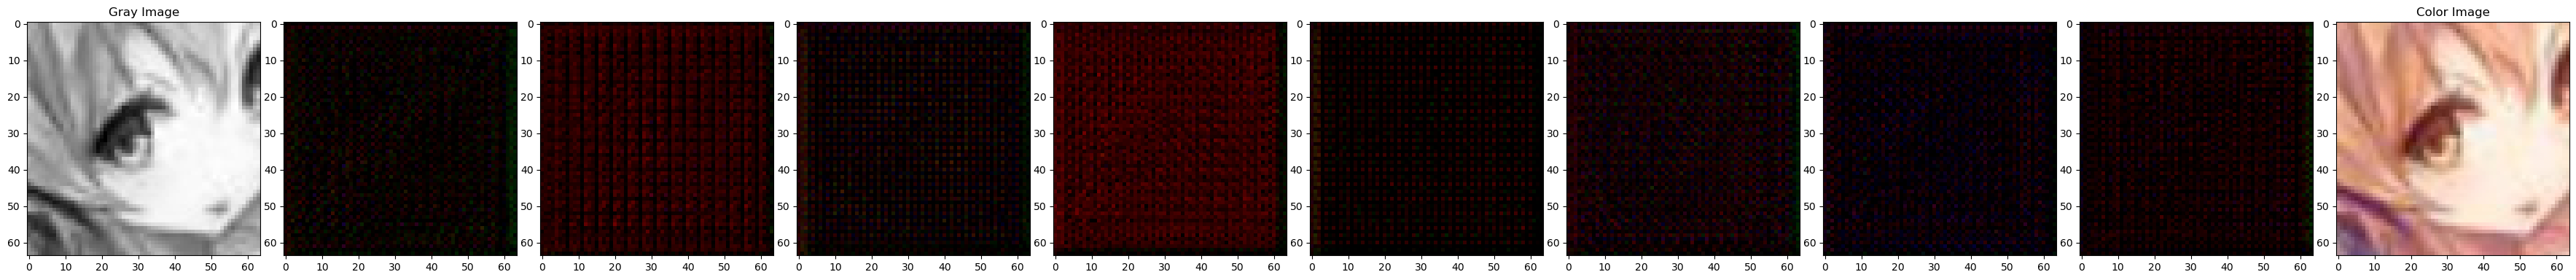

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.36557993..0.3315566].


--- tensor(-0.5663, device='cuda:0') tensor(0.5430, device='cuda:0') tensor(-0.6049, device='cuda:0') tensor(0.7462, device='cuda:0')
=== tensor(-0.9681, device='cuda:0') tensor(0.9668, device='cuda:0') tensor(0.0577, device='cuda:0') tensor(0.3817, device='cuda:0')
--- tensor(-0.5119, device='cuda:0') tensor(0.5343, device='cuda:0') tensor(-0.5411, device='cuda:0') tensor(0.5777, device='cuda:0')
=== tensor(-0.4846, device='cuda:0') tensor(0.4134, device='cuda:0') tensor(0.0403, device='cuda:0') tensor(0.2790, device='cuda:0')
--- tensor(-0.4749, device='cuda:0') tensor(0.4057, device='cuda:0') tensor(-0.3590, device='cuda:0') tensor(0.4290, device='cuda:0')
=== tensor(-0.2868, device='cuda:0') tensor(0.3733, device='cuda:0') tensor(0.0307, device='cuda:0') tensor(0.1938, device='cuda:0')
--- tensor(-0.4518, device='cuda:0') tensor(0.4850, device='cuda:0') tensor(-0.3650, device='cuda:0') tensor(0.4243, device='cuda:0')
=== tensor(-0.2339, device='cuda:0') tensor(0.2049, device='cuda:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.39191613..0.28166604].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.321013..0.14497408].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.45558473..0.30468825].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.36414653..0.30069116].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.41156557..0.2410113].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.30731165..0.2514684].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-

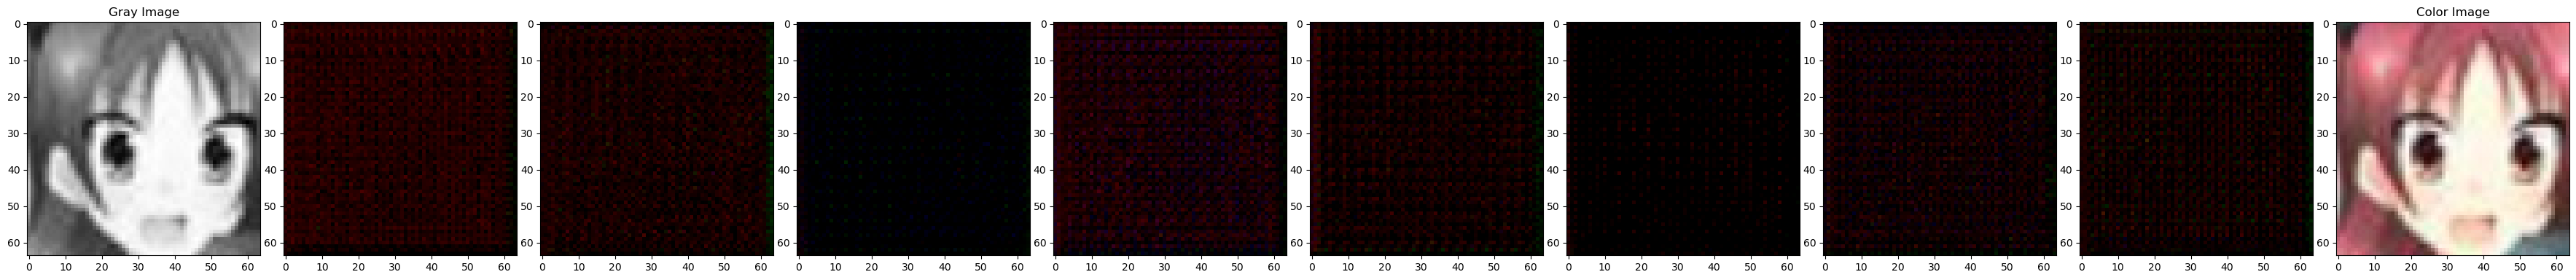

In [27]:
@T.no_grad()
def show_image(net=None, num=8):
    #
    if net==None:
        net = Generator().to(device)
    net.eval()
    #
    dataloader = DataLoader(Dataset_(path=path_test), batch_size=1, shuffle=True)
    n = 0
    for image_gray, image_color in dataloader:
        image_gray_show = image_gray.permute([0, 2, 3, 1]).squeeze().cpu().detach().numpy() #* 0.5 + 0.5
        image_color_show = image_color.permute([0, 2, 3, 1]).squeeze().cpu().detach().numpy() #* 0.5 + 0.5
        image_gray = image_gray.repeat([num, 1, 1, 1]).to(device)
        noise = T.randn([num, channels_condition, 1, 1], dtype=T.float32, device=device)
        outputs = net(image_gray, noise) #* 0.5 + 0.5
        print(outputs.min(), outputs.max())
        #
        plt.figure(figsize=(5*(num+1), 5*2))
        gs = plt.GridSpec(1, num+2)
        gs.update(wspace=0.1, hspace=0.1)
        plt.subplot(gs[0]), plt.imshow(image_gray_show, 'gray'), plt.title('Gray Image')
        plt.subplot(gs[num+1]), plt.imshow(image_color_show, 'gray'), plt.title('Color Image')
        for i in range(num):
            output = outputs[i,:,:,:].permute([1, 2, 0]).cpu().detach().numpy()
            plt.subplot(gs[i+1]), plt.imshow(output, 'gray')
        plt.show()
        n += 1
        if n == 2:
            break
    net.train()


show_image()

# Train

In [28]:
def gradient_penalty(y, x):
    """Compute gradient penalty: (L2_norm(dy/dx) - 1)**2."""
    weight = T.ones(y.shape).to(device)
    dydx = T.autograd.grad(y, x, grad_outputs=weight, retain_graph=True, create_graph=True)[0]
    dydx = dydx.reshape([dydx.shape[0], -1])
    dydx_l2norm = T.sqrt(T.sum(dydx**2, axis=1))
    return T.mean((dydx_l2norm-1)**2)

In [29]:
def trainer_d(net_d, optimizer_d, net_g, image_a, image_b):
    #
    src_real = net_d(image_b)
    image_a2b = net_g(image_a, T.randn([image_a.shape[0], channels_condition, 1, 1], dtype=T.float32, device=device))
    src_fake = net_d(image_a2b.detach())
    # gp
    α = T.rand([image_a.shape[0], 1, 1, 1]).to(device)
    image_fusion = α*image_b + (1-α)*image_a2b
    src_fusion = net_d(image_fusion)
    loss_gp = gradient_penalty(src_fusion, image_fusion)
    #
    loss = T.mean(src_fake) - T.mean(src_real) + λ_gp*loss_gp
    #
    optimizer_d.zero_grad()
    with T.autograd.detect_anomaly():
        loss.backward()
    optimizer_d.step()

In [30]:
def trainer_g(net_g, optimizer_g, net_d, image_a, image_b):
    #
    image_a2b = net_g(image_a, T.randn([image_a.shape[0], channels_condition, 1, 1], dtype=T.float32, device=device))
    src_fake = net_d(image_a2b)
    image_a2b2a = 0.299 * image_a2b[:,0,:,:] + 0.587 * image_a2b[:,1,:,:] + 0.114 * image_a2b[:,2,:,:]
    image_a2b2a = image_a2b2a[:,None,:,:]
    #
    loss = -T.mean(src_fake) + T.mean(T.abs(image_a2b2a - image_a)) * λ_pix
    print(loss)
    #
    optimizer_g.zero_grad()
    with T.autograd.detect_anomaly():
        loss.backward()
    optimizer_g.step()

In [31]:
def train(epochs, load_model, batch_size=batch_size):
    #
    net_d = Discriminator().to(device)
    net_d.train()
    net_g = Generator().to(device)
    net_g.train()
    optimizer_d = T.optim.Adam(net_d.parameters(), learning_rate_d, betas=(0.5,0.999))
    optimizer_g = T.optim.Adam(net_g.parameters(), learning_rate_g, betas=(0.5,0.999))
    if load_model:
        net_d.load_state_dict(T.load(path_work + 'net_d.pt'))
        net_g.load_state_dict(T.load(path_work + 'net_g.pt'))
        optimizer_d.load_state_dict(T.load(path_work + 'optimizer_d.pt'))
        optimizer_g.load_state_dict(T.load(path_work + 'optimizer_g.pt'))
        with open(path_work+'epoch.txt', 'r') as f:
            epoch_start = int(f.read())
    else:
        epoch_start = -1
    dataloader = DataLoader(Dataset_(path_train), batch_size=batch_size, shuffle=True, num_workers=num_workers)
    #
    iteration = 0
    time_start = time.time()
    for epoch in range(epoch_start+1, epochs):
        for image_gray, image_color in dataloader:
            iteration += 1
            image_gray, image_color = image_gray.to(device), image_color.to(device)
            trainer_d(net_d, optimizer_d, net_g, image_gray, image_color)
            if iteration % step_g == 0:
                trainer_g(net_g, optimizer_g, net_d, image_gray, image_color)
            #
            # if iteration % 100 == 0:
            #     show_image(net_g)
        #
        if epoch % 1 == 0:
            print('Epoch: ', epoch, ', Iteration: ', iteration, ', Time: ', time.time() - time_start)
            T.save(net_d.state_dict(), path_work + 'net_d.pt')
            T.save(net_g.state_dict(), path_work + 'net_g.pt')
            T.save(optimizer_d.state_dict(), path_work + 'optimizer_d.pt')
            T.save(optimizer_g.state_dict(), path_work + 'optimizer_g.pt')
            with open(path_work+'epoch.txt', 'w') as f:
                f.write(str(epoch))
            show_image(net_g)                
            time_start = time.time()

In [32]:
# train(1, False, batch_size=batch_size)

In [33]:
# train(200, True, batch_size=batch_size)

# Test

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-244.97983..434.94586].


--- tensor(-1.1300, device='cuda:0') tensor(0.7391, device='cuda:0') tensor(-1.0844, device='cuda:0') tensor(0.4597, device='cuda:0')
=== tensor(-1.3224, device='cuda:0') tensor(0.9299, device='cuda:0') tensor(0.0417, device='cuda:0') tensor(0.4171, device='cuda:0')
--- tensor(-2.9849, device='cuda:0') tensor(2.1846, device='cuda:0') tensor(-1.4695, device='cuda:0') tensor(1.2058, device='cuda:0')
=== tensor(-3.2094, device='cuda:0') tensor(0.9281, device='cuda:0') tensor(0.0627, device='cuda:0') tensor(0.7053, device='cuda:0')
--- tensor(-2.9073, device='cuda:0') tensor(0.8866, device='cuda:0') tensor(-1.0710, device='cuda:0') tensor(0.6572, device='cuda:0')
=== tensor(-2.6628, device='cuda:0') tensor(2.0327, device='cuda:0') tensor(0.0534, device='cuda:0') tensor(2.3836, device='cuda:0')
--- tensor(-0.9001, device='cuda:0') tensor(0.7962, device='cuda:0') tensor(-1.0002, device='cuda:0') tensor(0.3683, device='cuda:0')
=== tensor(-1.2534, device='cuda:0') tensor(0.7403, device='cuda:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-115.458145..199.73593].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-77.29215..139.1333].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-56.68402..80.63172].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-231.45697..416.43375].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-195.33179..343.11313].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-223.11536..421.004].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-201.00731..37

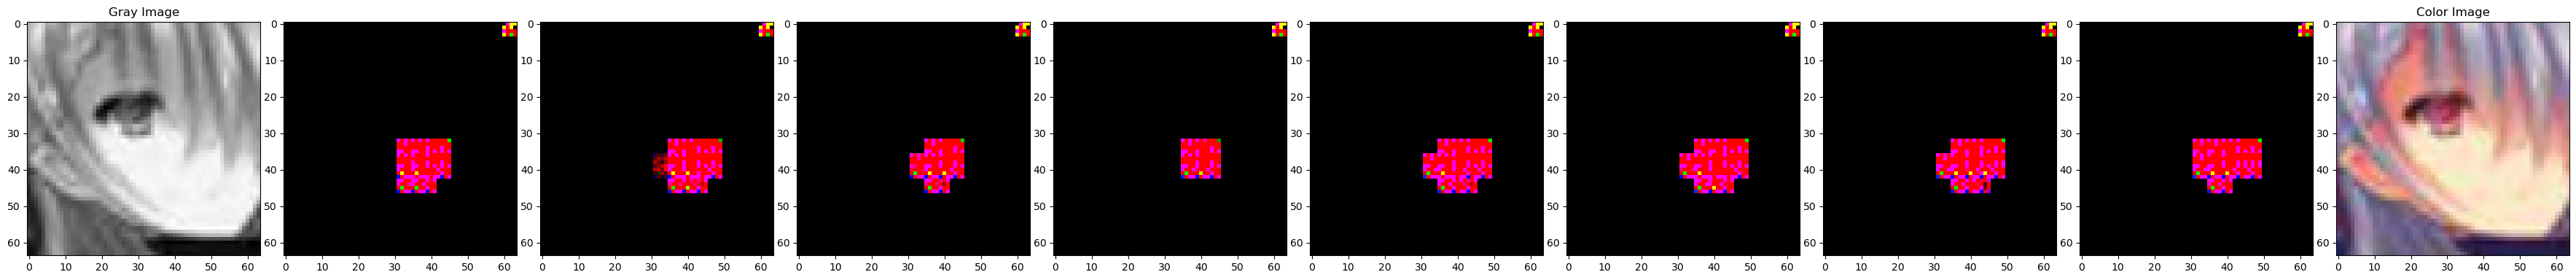

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-77.8902..66.30762].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-38.251648..32.563477].


--- tensor(-0.9407, device='cuda:0') tensor(0.5936, device='cuda:0') tensor(-0.9659, device='cuda:0') tensor(0.5116, device='cuda:0')
=== tensor(-1.2819, device='cuda:0') tensor(0.8973, device='cuda:0') tensor(0.0556, device='cuda:0') tensor(0.5027, device='cuda:0')
--- tensor(-3.0215, device='cuda:0') tensor(2.1869, device='cuda:0') tensor(-1.4722, device='cuda:0') tensor(1.0893, device='cuda:0')
=== tensor(-3.1334, device='cuda:0') tensor(0.9046, device='cuda:0') tensor(0.0525, device='cuda:0') tensor(0.6798, device='cuda:0')
--- tensor(-3.1625, device='cuda:0') tensor(1.0066, device='cuda:0') tensor(-1.0280, device='cuda:0') tensor(0.6956, device='cuda:0')
=== tensor(-3.3146, device='cuda:0') tensor(2.3756, device='cuda:0') tensor(0.0582, device='cuda:0') tensor(2.2977, device='cuda:0')
--- tensor(-0.9169, device='cuda:0') tensor(0.8418, device='cuda:0') tensor(-1.0091, device='cuda:0') tensor(0.4602, device='cuda:0')
=== tensor(-1.6491, device='cuda:0') tensor(0.9307, device='cuda:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-39.68329..33.782227].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-55.56555..47.302734].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-46.57306..39.64746].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-22.00029..18.72876].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-37.670044..32.06836].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-44.58872..71.570305].


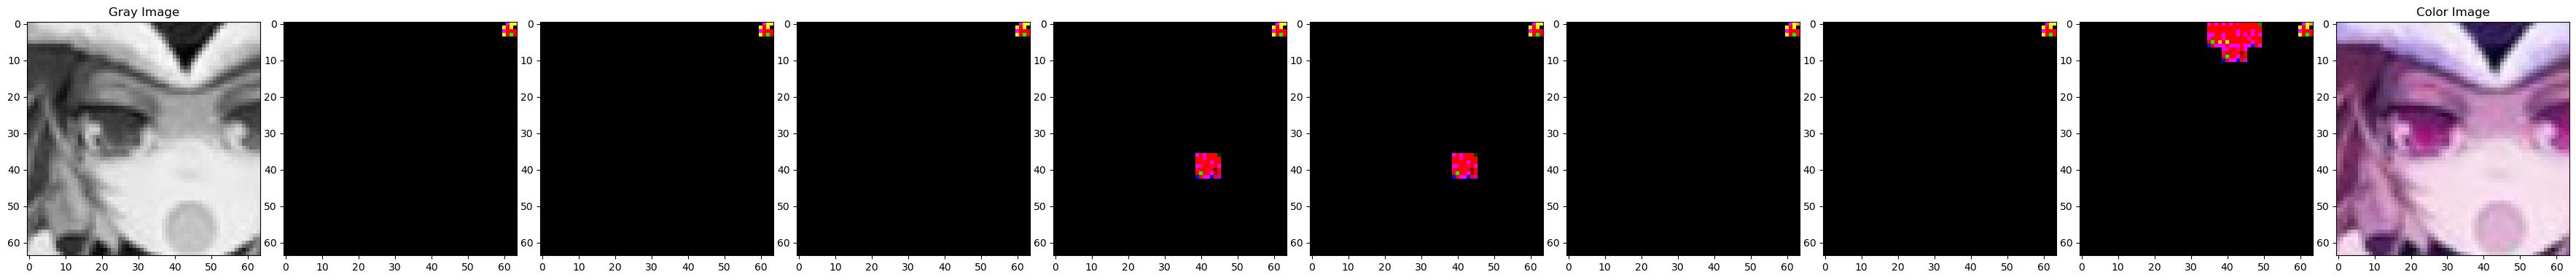

In [34]:
net = Generator().to(device)
net.load_state_dict(T.load(path_work+'net_g.pt'))
show_image(net)

# Export